In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from yellowbrick.cluster import SilhouetteVisualizer, InterclusterDistance
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import TransformerMixin, BaseEstimator
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
df = pd.read_csv('Consumidores.csv')
df.head()

,Timestamp,Qual sua faixa etária?,Qual seu gênero?,Você se considera um consumidor de Cachaça?,Você costuma consumir Cachaças Artesanais?,"Antes da pandemia, costumava comprar Cachaça online ou de maneira física?","Atualmente, na pandemia, costuma comprar Cachaça online ou de maneira física?",Quais destas bebidas você estaria disposto a comprar?,Por qual lugar você ficaria sabendo onde comprar?,Quais dessas Cachaças da Sanhaçu você teria interesse em comprar?
0,2021/05/10 10:09:13 PM GMT-3,18-28,Masculino,Não,Não,NaN,NaN,Cachaça;Gim;Cerveja;Whisky;Vodka;Rum;Tequila,"Propagandas na internet;Redes Socias(Twitter, ...",Freijó - Freijó é uma madeira da Amazônia que ...
1,2021/05/10 10:10:07 PM GMT-3,18-28,Masculino,Não,Não,Físico,Físico,Cachaça;Gim;Cerveja;Whisky;Vodka;Champanhe,Propagandas na internet,Carvalho - O carvalho é uma madeira importada....
2,2021/05/10 10:11:59 PM GMT-3,18-28,Masculino,Não,Não,NaN,NaN,NaN,NaN,NaN
3,2021/05/10 10:12:23 PM GMT-3,28-38,Masculino,Sim,Não,Físico,Físico,Cachaça;Gim;Cerveja;Whisky;Vodka;Rum;Champanhe...,"Redes Socias(Twitter, Instagram)",Umburana - Madeira encontrada em várias regiõe...
4,2021/05/10 10:12:47 PM GMT-3,48+,Masculino,Sim,Sim,Físico,Físico,Cachaça;Vodka,TV,"Origem - A Sanhaçu ORIGEM, como diz o nome, é ..."


#Tratamento de dados
Tendo em vista que retiramos dados de um google forms, é possivel que alguns dados estejam nulos(não preenchidos). Por esse motivos optamos por substituir esses valores por 0, pois isso indica que o usuário não realizou o evento o qual esvamos perguntando.

Ex:  No campo de "Quais destas bebidas você estaria disposto a comprar?" existem valores nulos que signica que o usuário não estaria disposto a adquirir nenhuma das opções dadas, nesse caso 0 representaria o grupo que não está disposto a adquirir nenhuma bebida.

Além disso, decidimos retirar a coluna de timestamp até o momento, pois atualmente ela apenas como um "user_id".

Para transformação dos dados, utilizamos um LabelEncoder() e normalizamos utilizando StandardScaler(). Para dados Categóricos normalmente se utiliza o OneHotEncoder(), porém como o formato dos dados fornecidos pelo forms tem uma particularidade, decidimos seguir com nossa própria implementação de um Transformer.

O principal motivo dessa escolha é que o OneHotEncoder iria criar uma coluna para cada categoria, porem tem categorias que contém mais de uma. Como por exemplo:

`Cachaça;Gim;Cerveja;Whisky;Vodka;Rum;Tequila` -> nesse caso o OneHotEncoder iria criar uma categoria exclusivamente para essa combinação e com a nossa implementação utilizamos apenas uma coluna para cada categoria(Cerveja, Tequila, Rum, ...) e preenchemos de forma binária. Assim reduzindo a dimensionalidade e ainda continua tratando as categorias de forma isolada.

In [ ]:
columns = ['user_id','Faixa_etaria', 'Genero', 'Consumidor_de_cachaca', 'Consumir_cachaca_artesanal',
              'Compras_antes_pandemia', 'Compras_durante_pandemia', 'Bebidas_dispostos_a_comprar',
              'Meio_de_divulgacao', 'produtos_sanhacu']
df.columns = columns

df.fillna(0, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   user_id                      101 non-null    object
 1   Faixa_etaria                 101 non-null    object
 2   Genero                       101 non-null    object
 3   Consumidor_de_cachaca        101 non-null    object
 4   Consumir_cachaca_artesanal   101 non-null    object
 5   Compras_antes_pandemia       101 non-null    object
 6   Compras_durante_pandemia     101 non-null    object
 7   Bebidas_dispostos_a_comprar  101 non-null    object
 8   Meio_de_divulgacao           101 non-null    object
 9   produtos_sanhacu             101 non-null    object
dtypes: object(10)
memory usage: 8.0+ KB


In [ ]:
class DummyTransformer(TransformerMixin, BaseEstimator):    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        columns = ['Bebidas_dispostos_a_comprar', 
                   'Meio_de_divulgacao', 
                   'produtos_sanhacu','Compras_antes_pandemia',
                   'Compras_durante_pandemia']

        for column in columns:
            str1 = ''.join(str(e)+';' for e 
                        in df[column].unique())
                    
            set1 = set(str1.split(';'))

            if '' in set1:
                set1.remove('')
            if '0' in set1:
                set1.remove('0')

            for val in set1:
                val = val.split("-")[0]
                df[val] = pd.Series([0 for x in range(len(df.index))])
                df[val] = df[column].apply(lambda x: (1 if str(val) in str(x) else 0))
            
        return X

In [ ]:
def encode_column(columns, encoder):
    for column in columns:
        df[column] = df[column].astype(str)
        df[column] = encoder.fit_transform(df[column]).reshape(-1, 1)

label = ['user_id','Faixa_etaria', 'Genero', 'Consumidor_de_cachaca', 'Consumir_cachaca_artesanal']

label_encoder = LabelEncoder()

encode_column(label, label_encoder)
dummy = DummyTransformer()

df = dummy.fit_transform(df)

df_transformed = df.copy()

df.drop(columns=['user_id', 'Bebidas_dispostos_a_comprar',
                 'Meio_de_divulgacao', 'produtos_sanhacu',
                 'Compras_antes_pandemia',
                 'Compras_durante_pandemia'], inplace=True)
df.head()

,Faixa_etaria,Genero,Consumidor_de_cachaca,Consumir_cachaca_artesanal,Whisky,Rum,Cerveja,Cachaça,Tequila,Vodka,Champanhe,Gim,Boca a Boca,TV,Influenciadores,Propagandas na internet,"Redes Socias(Twitter, Instagram)",Freijó,Carvalho,Origem,Umburana,Online,Físico
0,1,2,1,1,1,1,1,1,1,1,0,1,0,0,0,1,1,1,1,1,1,0,0
1,1,2,1,1,1,0,1,1,0,1,1,1,0,0,0,1,0,0,1,0,0,0,1
2,1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,2,2,1,1,1,1,1,1,1,1,1,0,0,0,0,1,0,0,0,1,0,1
4,4,2,2,2,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1


In [ ]:
#normalização
col = df.columns
scaler = StandardScaler()
df = scaler.fit_transform(df)
df = pd.DataFrame(df,columns = col)

In [ ]:
df.head()

,Faixa_etaria,Genero,Consumidor_de_cachaca,Consumir_cachaca_artesanal,Whisky,Rum,Cerveja,Cachaça,Tequila,Vodka,Champanhe,Gim,Boca a Boca,TV,Influenciadores,Propagandas na internet,"Redes Socias(Twitter, Instagram)",Freijó,Carvalho,Origem,Umburana,Online,Físico
0,-0.565488,0.693782,-0.702757,-0.671836,1.115547,2.304886,0.588784,1.071884,1.614665,1.138180,-0.650027,1.115547,-1.209717,-0.481360,-0.588784,1.185227,0.809776,1.614665,1.260850,1.614665,0.990148,-0.60404,-1.030158
1,-0.565488,0.693782,-0.702757,-0.671836,1.115547,-0.433861,0.588784,1.071884,-0.619324,1.138180,1.538397,1.115547,-1.209717,-0.481360,-0.588784,1.185227,-1.234909,-0.619324,1.260850,-0.619324,-1.009950,-0.60404,0.970725
2,-0.565488,0.693782,-0.702757,-0.671836,-0.896421,-0.433861,-1.698416,-0.932936,-0.619324,-0.878595,-0.650027,-0.896421,-1.209717,-0.481360,-0.588784,-0.843721,-1.234909,-0.619324,-0.793116,-0.619324,-1.009950,-0.60404,-1.030158
3,0.299880,0.693782,1.215579,-0.671836,1.115547,2.304886,0.588784,1.071884,1.614665,1.138180,1.538397,1.115547,-1.209717,-0.481360,-0.588784,-0.843721,0.809776,-0.619324,-0.793116,-0.619324,0.990148,-0.60404,0.970725
4,2.030616,0.693782,1.215579,1.266890,-0.896421,-0.433861,-1.698416,1.071884,-0.619324,1.138180,-0.650027,-0.896421,-1.209717,2.077448,-0.588784,-0.843721,-1.234909,-0.619324,-0.793116,1.614665,-1.009950,-0.60404,0.970725


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Faixa_etaria                      101 non-null    float64
 1   Genero                            101 non-null    float64
 2   Consumidor_de_cachaca             101 non-null    float64
 3   Consumir_cachaca_artesanal        101 non-null    float64
 4   Whisky                            101 non-null    float64
 5   Rum                               101 non-null    float64
 6   Cerveja                           101 non-null    float64
 7   Cachaça                           101 non-null    float64
 8   Tequila                           101 non-null    float64
 9   Vodka                             101 non-null    float64
 10  Champanhe                         101 non-null    float64
 11  Gim                               101 non-null    float64
 12  Boca a B

#KMeans Clustering


## Selecionando e criando um modelo
Como nosso objetivo é identificar o perfil do nosso usuário, aplicamos uma tecnica de aprendizagem não-supervisionada utilizando KMeans().

Treinamos o modelo com quantidade de 1 até 15 clusters. Fizemos a utilização de um gráfico do cotovelo utilizando da distorção para defirnir a melhor quantidade de clusters, porém não conseguimos identificar a melhor quantidade utilizando somente essa técnica. Devido a isso, partimos para uma avaliação utilizando o método da silhueta.

No método da silhueta, chegamos a conclusão que o melhor número de clusters é 7, pois no gráfico de 7 clusters todos os pontos estão acima da média de silhoutte_score. Não escolhemos 5 ou 8 clusters pela consistencia dos clusters, que apresentão diferenças nas 'larguras'. Por fim, decidimos continuar com o número de clusters = 7.

Também utilizamos o método de calculo de distancia entre os clusters. E podemos validar que existe uma boa relação entra as distancias.

Após o treinamento e seleção de número de cluster utilizamos um PCA() para reduzir a dimensionalidade da predição e após isso plotar uma visualização do cluster.

---------------

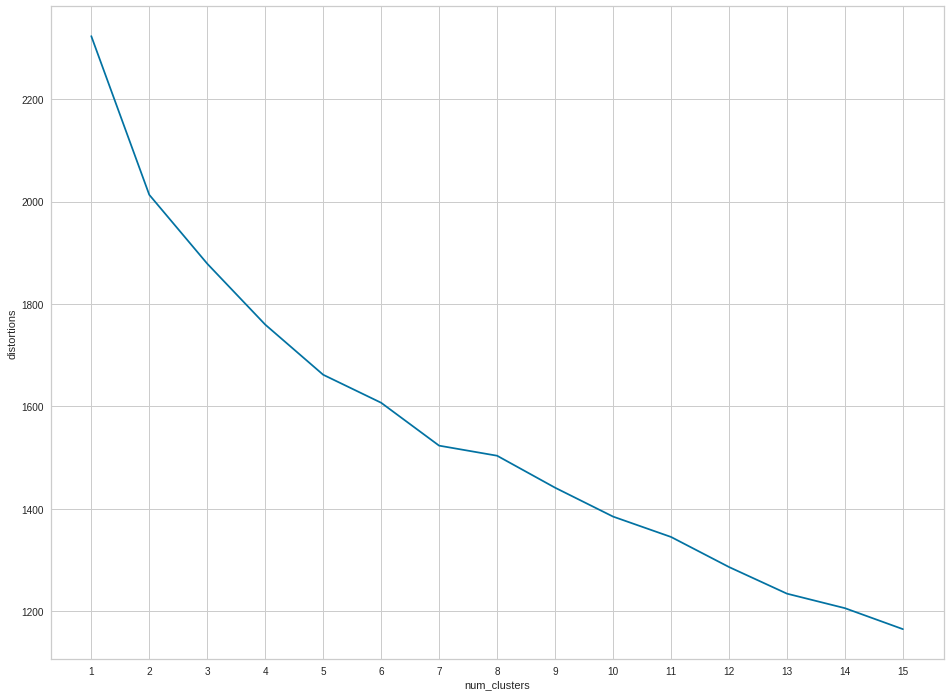

In [ ]:
distortions = []
num_clusters =  range(1,16)


for n in num_clusters:
    print("-", end = '')
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(df)
    distortions.append(kmeans.inertia_)

fig = plt.figure(figsize=(16, 12))    
elbow_plot = pd.DataFrame({'num_clusters': num_clusters, 'distortions': distortions})
sns.lineplot(x='num_clusters', y='distortions', data = elbow_plot)
plt.xticks(num_clusters)
plt.show()

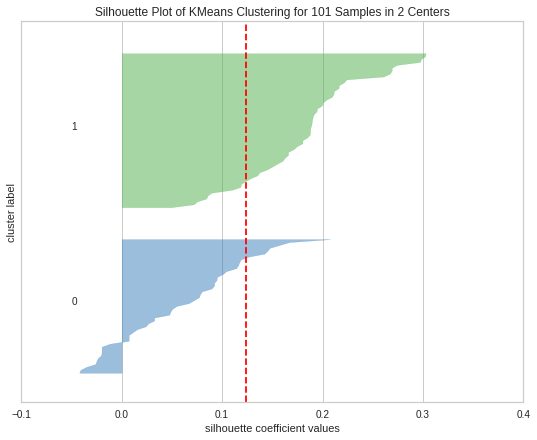

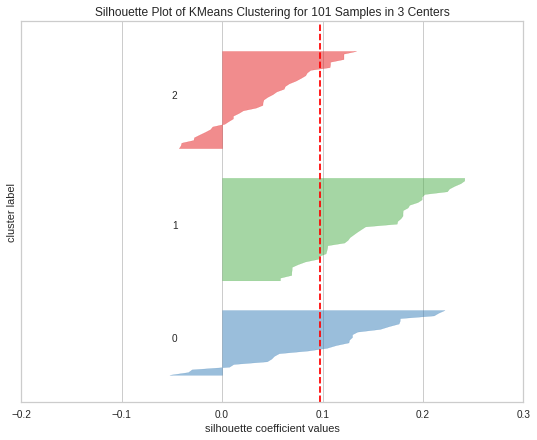

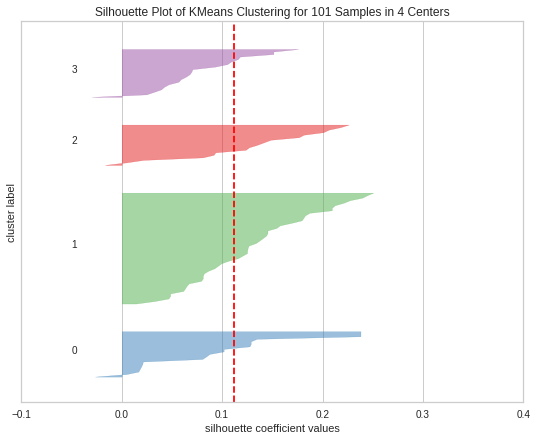

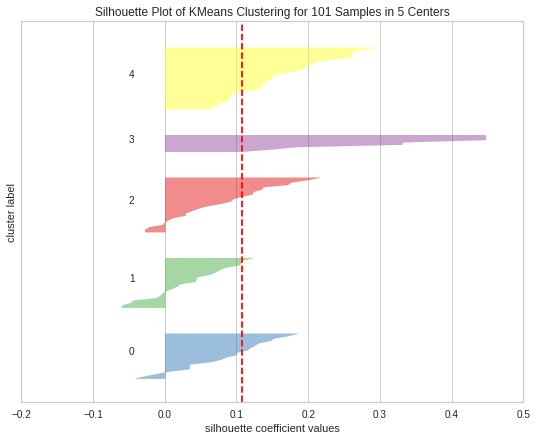

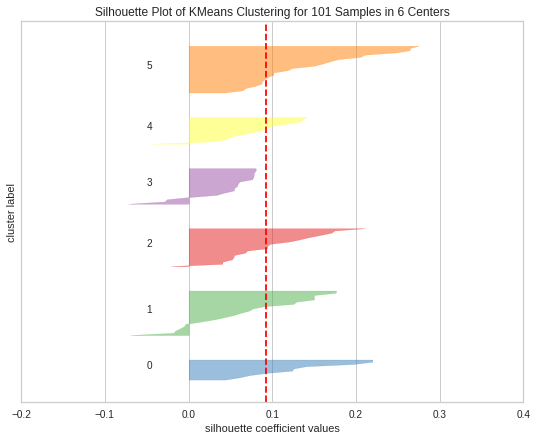

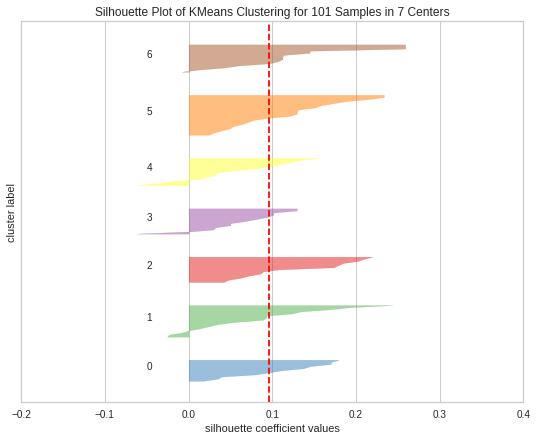

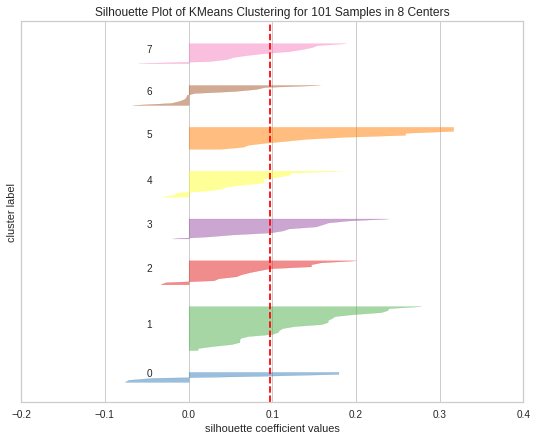

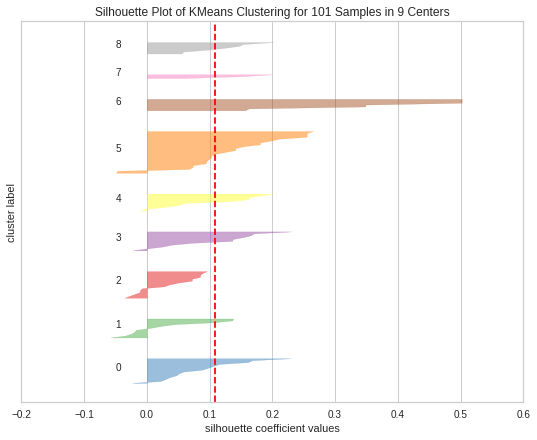

In [ ]:
for i in range(2,10):
    fig = plt.figure(figsize=(9, 7))
    model = KMeans(i, random_state=42)
    visualizer = SilhouetteVisualizer(model)
    visualizer.fit(df)
    visualizer.poof()

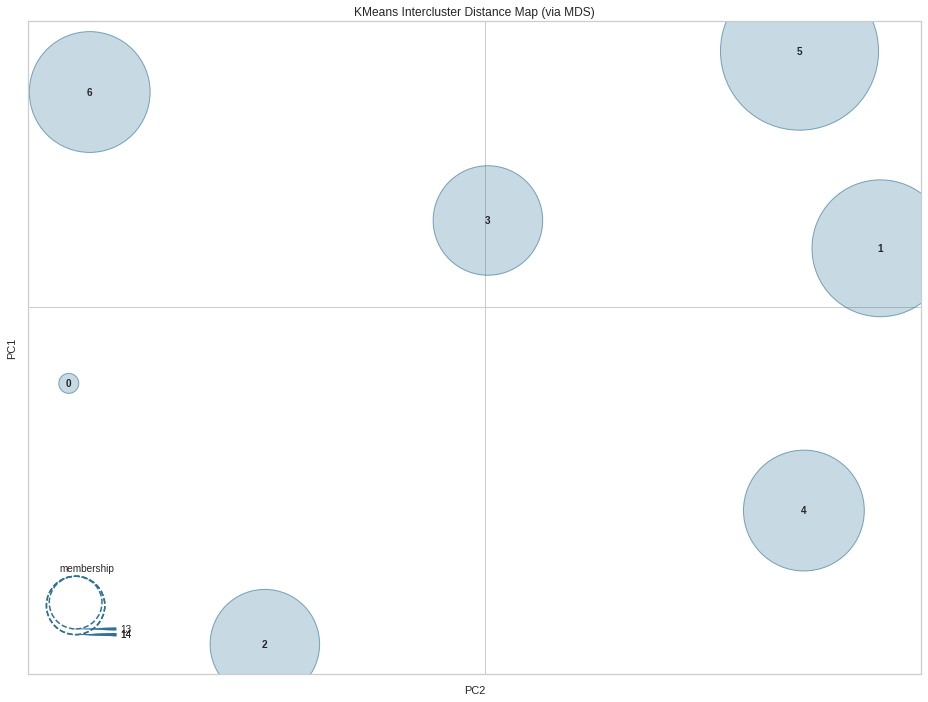

In [ ]:
fig = plt.figure(figsize=(16, 12))
model = KMeans(7, random_state=42)
visualizer = InterclusterDistance(model)
visualizer.fit(df)
visualizer.poof()    

In [ ]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(df)
cluster_pred = kmeans.predict(df)
print("kmeans Predict:\n{}\n".format(cluster_pred))
print("Clustering Score:\n{}".format(kmeans.inertia_))

kmeans Predict:
[2 3 4 2 6 4 5 4 3 4 2 5 3 3 0 2 3 3 4 4 6 4 3 4 4 3 2 4 6 2 1 2 2 4 3 1 1
 2 6 4 4 6 4 1 1 2 1 6 6 4 0 4 1 3 0 6 3 4 1 4 3 2 3 4 3 3 4 0 2 1 6 1 3 2
 4 0 4 1 3 3 2 0 6 2 5 0 5 4 1 3 6 1 1 1 6 1 6 2 6 2 1]

Clustering Score:
1533.2807684950046


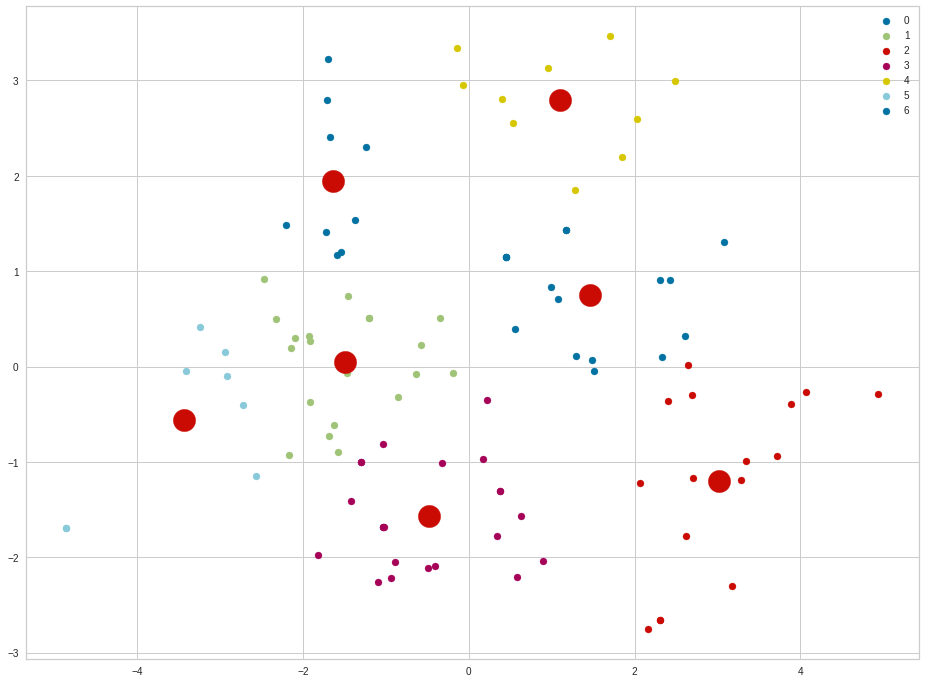

In [ ]:
pca = PCA(2)

df = pca.fit_transform(df)
label = kmeans.fit_predict(df)
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)

fig = plt.figure(figsize=(16, 12))

for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 500, color = 'r')
plt.legend()
plt.show()

In [ ]:
df = pd.read_csv('Consumidores.csv')
df['Clusters'] = cluster_pred
df = df.sort_values('Clusters')
df["Timestamp"] = label_encoder.fit_transform(df["Timestamp"])
df.rename(columns={'Timestamp': 'user_id'}, inplace=True)
df.to_csv('clusters.csv')

In [ ]:
df.head()

,user_id,Qual sua faixa etária?,Qual seu gênero?,Você se considera um consumidor de Cachaça?,Você costuma consumir Cachaças Artesanais?,"Antes da pandemia, costumava comprar Cachaça online ou de maneira física?","Atualmente, na pandemia, costuma comprar Cachaça online ou de maneira física?",Quais destas bebidas você estaria disposto a comprar?,Por qual lugar você ficaria sabendo onde comprar?,Quais dessas Cachaças da Sanhaçu você teria interesse em comprar?,Clusters
50,49,38-48,Masculino,Sim,Sim,Físico,Online;Físico,Cachaça;Cerveja,"Influenciadores;Redes Socias(Twitter, Instagram)",Carvalho - O carvalho é uma madeira importada....,0
85,77,38-48,Masculino,Sim,Sim,Físico,Online,Cachaça;Cerveja;Whisky;Champanhe,"Propagandas na internet;Redes Socias(Twitter, ...",Carvalho - O carvalho é uma madeira importada....,0
81,70,38-48,Masculino,Sim,Sim,Físico,Online;Físico,Cachaça;Cerveja,"Influenciadores;Redes Socias(Twitter, Instagram)",Carvalho - O carvalho é uma madeira importada....,0
54,53,28-38,Feminio,Não,Não,Físico,Online,Cachaça;Cerveja;Champanhe;Tequila,"Propagandas na internet;Redes Socias(Twitter, ...",Carvalho - O carvalho é uma madeira importada....,0
75,62,28-38,Masculino,Sim,Sim,Online;Físico,Online,Cachaça;Gim;Cerveja;Whisky,Influenciadores;Propagandas na internet;Redes ...,Freijó - Freijó é uma madeira da Amazônia que ...,0


In [ ]:
columns = ['user_id','Faixa_etaria', 'Genero', 'Consumidor_de_cachaca', 'Consumir_cachaca_artesanal',
              'Compras_antes_pandemia', 'Compras_durante_pandemia', 'Bebidas_dispostos_a_comprar',
              'Meio_de_divulgacao', 'produtos_sanhacu', 'Clusters']
df.columns = columns

def encode_column(columns, encoder):
    for column in columns:
        df[column] = df[column].astype(str)
        df[column] = encoder.fit_transform(df[column]).reshape(-1, 1)

label = ['user_id','Faixa_etaria', 'Genero', 'Consumidor_de_cachaca', 'Consumir_cachaca_artesanal']

label_encoder = LabelEncoder()

encode_column(label, label_encoder)
dummy = DummyTransformer()

df = dummy.fit_transform(df)

df_transformed = df.copy()

df.drop(columns=['user_id', 'Bebidas_dispostos_a_comprar',
                 'Meio_de_divulgacao', 'produtos_sanhacu',
                 'Compras_antes_pandemia',
                 'Compras_durante_pandemia'], inplace=True)
df.head()

,Faixa_etaria,Genero,Consumidor_de_cachaca,Consumir_cachaca_artesanal,Clusters,Whisky,Rum,Cerveja,nan,Cachaça,Tequila,Vodka,Champanhe,Gim,Boca a Boca,TV,Influenciadores,Propagandas na internet,"Redes Socias(Twitter, Instagram)",Freijó,Carvalho,Origem,Umburana,Online,Físico
50,2,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,1,1
85,2,1,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,1,0
81,2,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,1,1
54,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,1,1,0,1,0,1,1,0
75,1,1,1,1,0,1,0,1,0,1,0,0,0,1,1,0,1,1,1,1,1,0,1,1,0


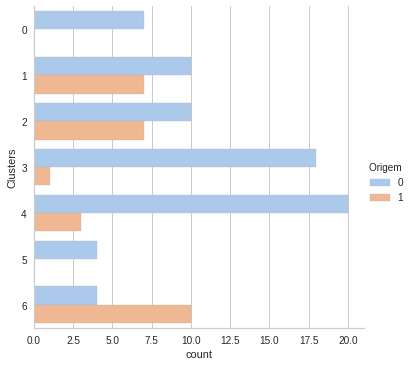

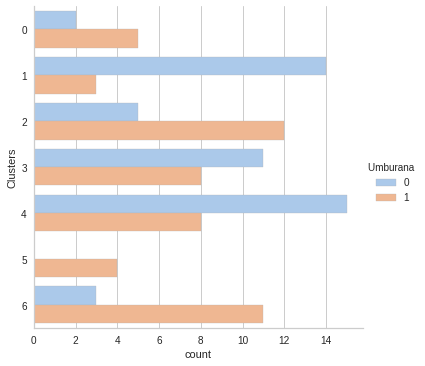

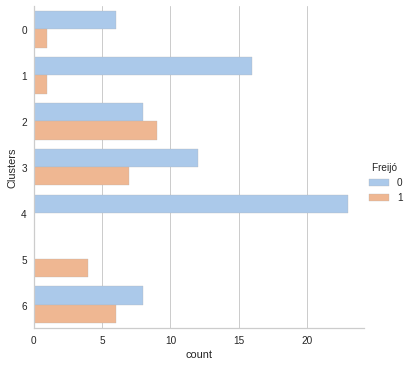

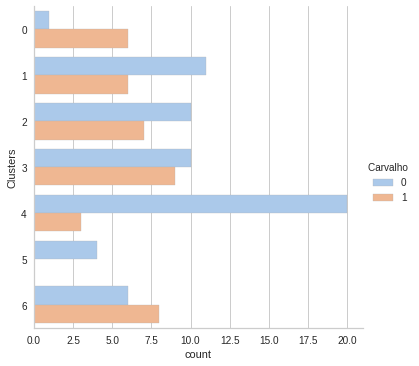

In [ ]:
a = sns.catplot(y="Clusters", hue="Origem ", kind="count",
            palette="pastel", edgecolor=".7",
            data=df)

b = sns.catplot(y="Clusters", hue="Umburana ", kind="count",
            palette="pastel", edgecolor=".7",
            data=df)

c = sns.catplot(y="Clusters", hue="Freijó ", kind="count",
            palette="pastel", edgecolor=".7",
            data=df)

d = sns.catplot(y="Clusters", hue="Carvalho ", kind="count",
            palette="pastel", edgecolor=".7",
            data=df)

#Recommendation Engine
Funciona através da similaridade entre 2 usuarios, então vou o que cada 'user' votou para os tipos de cachaça.
Como Ainda não temos nenhum website ativo tivemos que simular as interações dos usuário com os produtos da cachaçaria sanhaçu.
Portanto, criamos algumas funcões para gerar mais usuários. Além disso também geramos iterações com usuários de forma aleátoria em 3 eventos:
- CLICK com probabilidade de 4/7
- ADD2CART com probabilidade de 2/7
- BUY com probabilidade de 1/7

Escolhemos utilizar o algoritimo Singular Value Decomposition que explicaremos seu funcionamento mais à frente. A sua implementação é feita pela biblioteca scikit-surprise. Devido a limitações da própria biblioteca tivermos que adaptar o nosso dataset de interações de usuário. 
A scikit-surprise aceita somente 3 colunas por padrão `userID`, `rating`e `itemID`. O atributo `rating` seria nossa adaptação, pois temos sometente iterações e não notas, mas conseguimos adaptar as iterações para virarem notas atribuindo pesoas às interações e atribuindo o valor da média desses pesos para cada item.

In [ ]:
df.head()

,Faixa_etaria,Genero,Consumidor_de_cachaca,Consumir_cachaca_artesanal,Clusters,Whisky,Rum,Cerveja,nan,Cachaça,Tequila,Vodka,Champanhe,Gim,Boca a Boca,TV,Influenciadores,Propagandas na internet,"Redes Socias(Twitter, Instagram)",Freijó,Carvalho,Origem,Umburana,Online,Físico
50,2,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,1,1
85,2,1,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,1,0
81,2,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,1,1
54,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,1,1,0,1,0,1,1,0
75,1,1,1,1,0,1,0,1,0,1,0,0,0,1,1,0,1,1,1,1,1,0,1,1,0


In [ ]:
#Creating dummy interactions dataset
df_transformed.drop(columns=['Bebidas_dispostos_a_comprar',
                             'Meio_de_divulgacao', 'produtos_sanhacu',
                             'Compras_antes_pandemia',
                             'Compras_durante_pandemia', 'Faixa_etaria',
                             'Genero', 'Consumidor_de_cachaca',
                             'Consumir_cachaca_artesanal',
                             'Redes Socias(Twitter, Instagram)',
                             'Influenciadores', 'Boca a Boca',
                             'Propagandas na internet', 'TV'], inplace=True)
df_transformed.head()

,user_id,Clusters,Whisky,Rum,Cerveja,nan,Cachaça,Tequila,Vodka,Champanhe,Gim,Freijó,Carvalho,Origem,Umburana,Online,Físico
50,44,0,0,0,1,0,1,0,0,0,0,0,1,0,1,1,1
85,75,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0
81,68,0,0,0,1,0,1,0,0,0,0,0,1,0,1,1,1
54,49,0,0,0,1,0,1,1,0,1,0,0,1,0,1,1,0
75,59,0,1,0,1,0,1,0,0,0,1,1,1,0,1,1,0


In [ ]:
df_interactions = df_transformed[['user_id', 'Umburana ', 'Origem ', 'Freijó ', 'Carvalho ']]
df_interactions.head()

,user_id,Umburana,Origem,Freijó,Carvalho
50,44,1,0,0,1
85,75,0,0,0,1
81,68,1,0,0,1
54,49,1,0,0,1
75,59,1,0,1,1


In [ ]:
def get_more_users(df):
    for new_user in range(2000):
        df = df.append({
            'user_id': max(df['user_id']) + 1,
            'Umburana ': random.choice([0, 1]),
            'Origem ': random.choice([0, 1]),
            'Freijó ': random.choice([0, 1]),
            'Carvalho ': random.choice([0, 1])
        }, ignore_index=True)
    return df

In [ ]:
df_interactions = get_more_users(df_interactions)
df_interactions

,user_id,Umburana,Origem,Freijó,Carvalho
0,44,1,0,0,1
1,75,0,0,0,1
2,68,1,0,0,1
3,49,1,0,0,1
4,59,1,0,1,1
...,...,...,...,...,...
2096,2095,1,0,1,0
2097,2096,1,0,0,0
2098,2097,1,1,0,0
2099,2098,0,0,1,0


In [ ]:
def interaction_generator(df):
    """Create a fake interaction dataset.""" 
    interactions = ["CLICK", "CLICK", "BUY", "CLICK", "ADD2CART", "CLICK", "ADD2CART"]
    column = ['USER_ID', 'EVENT_TYPE', 'ITEM_ID']
    df_new = pd.DataFrame(columns=column)

    for index, row in df.iterrows():
        num_inter = random.randint(1,7)
        names = ['Umburana ', 'Origem ','Freijó ', 'Carvalho ']
        products = dict(zip(names, row[['Umburana ', 'Origem ','Freijó ', 'Carvalho ']]))

        for product in products:
            for i in range(num_inter):
                if products[product] == 1:
                    interaction = random.sample(interactions, 1)
                    new_row = pd.DataFrame({'USER_ID': row['user_id'],
                            'EVENT_TYPE': interaction,
                            'ITEM_ID': product})
                    df_new = df_new.append(new_row, ignore_index=True)

    return df_new

In [ ]:
df_interactions = interaction_generator(df_interactions)
df_interactions = df_interactions.sample(frac=1).reset_index(drop=True)
df_interactions

,USER_ID,EVENT_TYPE,ITEM_ID
0,324,CLICK,Umburana
1,1802,CLICK,Carvalho
2,405,CLICK,Freijó
3,1026,ADD2CART,Umburana
4,1853,BUY,Origem
...,...,...,...
16390,795,ADD2CART,Origem
16391,668,BUY,Origem
16392,1033,CLICK,Origem
16393,377,CLICK,Freijó


In [ ]:
fake_ratings = \
{
'CLICK': 1,
'ADD2CART': 2,
'BUY': 5
}

df_interactions["USER_ID"] = pd.to_numeric(df_interactions["USER_ID"])
df_interactions["EVENT_TYPE"] = df_interactions["EVENT_TYPE"].map(fake_ratings)
df_interactions["ITEM_ID"] = label_encoder.fit_transform(df_interactions["ITEM_ID"])
df_interactions.head()

,USER_ID,EVENT_TYPE,ITEM_ID
0,324,1,3
1,1802,1,0
2,405,1,1
3,1026,2,3
4,1853,5,2


In [ ]:
df_ratings = df_interactions.copy()
df_ratings.columns = ['userID', 'rating','itemID']
df_ratings

,userID,rating,itemID
0,324,1,3
1,1802,1,0
2,405,1,1
3,1026,2,3
4,1853,5,2
...,...,...,...
16390,795,2,2
16391,668,5,2
16392,1033,1,2
16393,377,1,1


In [ ]:
df_ratings = df_ratings.groupby(['userID','itemID']).mean().reset_index()
df_ratings

,userID,itemID,rating
0,0,0,2.333333
1,0,1,1.500000
2,0,2,1.500000
3,0,3,1.666667
4,1,0,1.333333
...,...,...,...
4106,2097,2,1.714286
4107,2097,3,2.571429
4108,2098,1,1.500000
4109,2099,0,2.000000


In [ ]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8MB 240kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617678 sha256=caf5488630f098495d92033d194c2f390c54b226ba155a04be66f5e721e06877
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


## Singular Value Decomposition

O algoritmo de SVD é um método baseado em decomposição em matrizes que performa muito bem para soluções de recomendação utilizando colaborative filtering. Em uma breve explicação, podemos estimar o valor que um usuário irá dar para um determinado item de acordo com o comportamendo de usuário que tem gostos semelhantes.
Para isso utilizamos uma decomposição de matrizes, onde separamos uma matriz para usuários e outra para items. A partir disso, utilizamos as duas matrizes decompostas para aproximar cada vez mais da matriz real e diminuir o erro. Quando isso é atingido podemos estimar os valores em branco pela a matriz decomposta

Ex:

Temos a seguinte matris onde 4 usuários tem sua preferencia para cada item que seriam as linhas da tabela

|USR1 | USR2  | USR3  | USR4
|---|---|---|---|
|  X |  X | 3  |  3 |
|  2 |  X |  1 |  X |
|  1 |  5 |  5 |  1 |

\\
A partir dai iremos decompor a matriz em 2 matrizes 1 de usuários e outra de items

\

|FEATURE USR|USR1 | USR2  | USR3  | USR4
|---|---|---|---|---|
|F1 |0.9 | 0.11  | 1  | 1.14
|F2 |0.14 | 0.3  | 0  | 2.06

\

|FEATURE ITEM| 024 | 171  | 009 |
|---|---|---|---|
|F1 |0.7 | 0.11  | 0  |
|F2 |0.5 | 0.9  | 3  |

\

|ITEM |USR1 | USR2  | USR3  | USR4
|---|---|---|---|---|
|024|  X |  X | 3  |  3 |
|171|  2 |  X |  1 |  X |
|009|  1 |  5 |  5 |  1 |

\

Note que as com as matrizes decompotas foram gerados valores aleatórios que são representados como features, nesse caso utilizaremos 2.
Agora tentaremos aproximar ao máximo os valores reais da tabela utilizando as features, nesse caso iremos aplicar para o USR1 e ITEM 171.
Para esse valores temos (ITEM-F1 * ITEM-F2) + (USR-F1 * USR-F2) -> (1 * 0.9) + (0.9 * 0.14) = 1.026.

O USR tem um score real de 2 para o ITEM 171 então precisamos aumentar esse valor das features levemente até chegarmos a um valor optimo. E isso é feito por diante para cada termo da matriz.

Porém essa decisão de aumentar ou diminuir as features não são feitas de forma aleatória, para isso precisamos de utilizar uma Função de erro. Com base nisso podemos utilizar o método de gradiente descente para encontrar esse valor optimo das features.

\

|FEATURE USR|USR1 | USR2  | USR3  | USR4
|---|---|---|---|---|
|F1 |0.9 | 0.11  | 1  | 1.14
|F2 |0.14 | 0.3  | 0  | 2.06

\

|FEATURE ITEM| 024 | 171  | 009 |
|---|---|---|---|
|F1 |0.9 | 0.9  | 1  |
|F2 |0.14 | 1  | 0  |

\

|ITEM |USR1 | USR2  | USR3  | USR4
|---|---|---|---|---|
|024|  X |  X | 3  |  3 |
|171|  2 |  X |  1 |  X |
|009|  1 |  5 |  5 |  1 |

\

In [ ]:
import pprint
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split, GridSearchCV
from surprise import accuracy

In [ ]:
reader = Reader(rating_scale=(1, 5), line_format="user rating item")
data = Dataset.load_from_df(df_ratings, reader)
trainset, testset = train_test_split(data, test_size=.25)

param_grid = {'n_epochs': [20, 30, 40, 50, 60, 70, 80],
              'lr_all': [0.001, 0.002, 0.005, 0.01],
              'reg_all': [0.02, 0.04, 0.06, 0.1, 0.14]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=10)

gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8239683454335586
{'n_epochs': 20, 'lr_all': 0.001, 'reg_all': 0.1}


In [32]:
#Fine tune SVD grid

epochs_fine_tunning = np.arange(gs.best_params['rmse']['n_epochs'] - 11,
                                      gs.best_params['rmse']['n_epochs'] + 11)

lr_fine_tunning = np.linspace(gs.best_params['rmse']['lr_all'] / 2,
                              gs.best_params['rmse']['lr_all'] * 2,
                              num=10)

reg_fine_tunning = np.linspace(gs.best_params['rmse']['reg_all'] / 2,
                              gs.best_params['rmse']['reg_all'] * 2,
                              num=10)

param_grid = {'n_epochs': epochs_fine_tunning,
              'lr_all': lr_fine_tunning,
              'reg_all': reg_fine_tunning}
gsf = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=10)

gsf.fit(data)

print(gsf.best_score['rmse'])
print(gsf.best_params['rmse'])

0.823196093240566
{'n_epochs': 17, 'lr_all': 0.0008333333333333333, 'reg_all': 0.1}


In [33]:
svd = SVD(**gsf.best_params['rmse'])
svd.fit(trainset)
pred = svd.test(testset)
accuracy.rmse(pred)

RMSE: 0.8239


0.8238523908566456

In [34]:
# Train production SVD

svd = SVD(**gsf.best_params['rmse'])
svd.fit(data.build_full_trainset())

In [35]:
iterated_users = []

for user in range(5):
    data = {}
    iterated_users.append(user)
    if user in iterated_users:
        user = user + random.randint(0,1234567) 

    sample_user = df_ratings[df_ratings['userID'] <= 90].sample(n=1, random_state=user)
    sample_user = sample_user.to_dict('r')[0]
    sample_userid = sample_user['userID']
    for item in range(4):
        pred = svd.predict(uid=sample_userid, iid=item)

        real = df_ratings[(df_ratings['userID'] == sample_userid) &
                                       (df_ratings['itemID'] == item)].to_dict('r')
        if real:
            real = real[0]
        else:
            real = dict()
            real['rating'] = 0
        
        est_real = {'estimado': pred.est,
                    'real': float(real['rating'])}
        data[item] = est_real
        data[item]['estimado'] = round(data[item]['estimado'], 5)
        data[item]['real'] = round(data[item]['real'], 5)

    print('User:{} \nEstimations:'.format(sample_user['userID']))
    pprint.pprint(data, width=1)

# Note que quando os resultados reais são iguais a zero é porque o usuário
# nunca interagiu com esse item, ou seja, seria a recomendação do nosso modelo
# para ele

User:41 
Estimations:
{0: {'estimado': 1.80788,
     'real': 1.25},
 1: {'estimado': 1.86329,
     'real': 1.0},
 2: {'estimado': 1.81021,
     'real': 2.75},
 3: {'estimado': 1.86483,
     'real': 2.5}}
User:33 
Estimations:
{0: {'estimado': 1.772,
     'real': 1.83333},
 1: {'estimado': 1.8294,
     'real': 0.0},
 2: {'estimado': 1.84556,
     'real': 0.0},
 3: {'estimado': 1.80364,
     'real': 0.0}}
User:82 
Estimations:
{0: {'estimado': 1.84886,
     'real': 0.0},
 1: {'estimado': 1.83376,
     'real': 1.85714},
 2: {'estimado': 1.82461,
     'real': 0.0},
 3: {'estimado': 1.84245,
     'real': 2.28571}}
User:15 
Estimations:
{0: {'estimado': 1.8474,
     'real': 1.0},
 1: {'estimado': 1.8341,
     'real': 1.25},
 2: {'estimado': 1.81285,
     'real': 2.6},
 3: {'estimado': 1.80081,
     'real': 1.88889}}
User:42 
Estimations:
{0: {'estimado': 1.82712,
     'real': 1.5},
 1: {'estimado': 1.82343,
     'real': 0.0},
 2: {'estimado': 1.84365,
     'real': 2.5},
 3: {'estimado': 1.79

## Resultados

Analisando o nosso modelo de algoritimo de recomendação, tivemos um RMSE Score muito consistente entre os conjustos de teste e de treino. Isso indica que nosso modelo conseguiu generelizar bem com dados não vistos.

Além disso, pode parecer que temos um RMSE muito alto de aproximadamente 0.823. Porém é um valor relevante para o nosso modelo, na documentação do scikit-surprise, mostra que de ratings de 1-5 valores abaixo de 0.9 são resultados consistentes. Porém a biblioteca não é uma implementação muito robusta, existem outros recursos que podemos utilizar como o tensorflow para desenvolver um modelo muito mais performatico.